<h1>Personalized Book Search</h1>

In [1]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /Users/heejoojin/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
import numpy as np
import pandas as pd
import surprise
import sklearn
import plotnine

from plotnine import *
from nltk.corpus import words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
base_path = 'https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/'

book_tags = pd.read_csv(base_path + 'book_tags.csv')
books = pd.read_csv(base_path + 'books.csv')
ratings = pd.read_csv(base_path + 'ratings.csv')
tags = pd.read_csv(base_path + 'tags.csv')
to_read = pd.read_csv(base_path + 'to_read.csv')


---
<h1>Exploratory Data Analysis</h1>

<h2>Average Rating Distribution</h2>

From the plot below, we can learn that:
- The majority of the books has the score of 3.7 - 4.3.
- Books with the perfect score is really rare.

<h3>Therefore, we don't want to recommend movies with lower rating than 3.2.</h3>

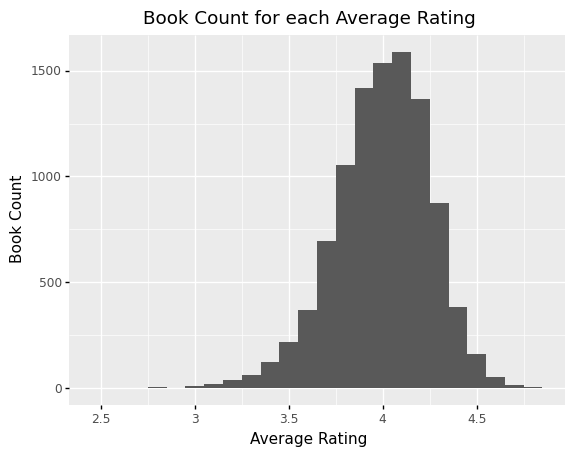

<ggplot: (8792991564391)>

In [ ]:
(ggplot(data=books)
    + geom_histogram(aes(x='average_rating'), binwidth=0.1)
    + labs(title='Book Count for each Average Rating', x='Average Rating', y='Book Count')
)

<h2>Average Rating vs Rating Count</h2>

From the two tables below, we can learn that:
- Just because the average rating is high, that does not guarantee that they are the best-selling/ the most popular books.
    - For example, "ESV Study Bible" has less rating count but its average rating is as high as "Words of Radiance (The Stormlight Archive, #2)" which has a greater rating count than "ESV Study Bible".
    - "Twilight" has more rating count than "ESV Study Bible" but the average rating of "Twilight" is much lower than "ESV Study Bible".

<h3>Since average rating and rating count are not always proportionally related, we will utilize IMDd weighted rating.</h3> (https://en.wikipedia.org/wiki/IMDb) 

- W (weighted rating of a chosen book) = (R * v + C * m) / (v, m)
    - R = average rating of the chosen book,
    - v = rating count for the chosen book,
    - C = mean average rating across all books,
    - m = minimum rating count required to be listed in the dataset


In [ ]:
books[['book_id', 'authors', 'title', 'average_rating', 'ratings_count']].sort_values(by='average_rating', ascending=False).head()

,book_id,authors,title,average_rating,ratings_count
3627,3628,Bill Watterson,The Complete Calvin and Hobbes,4.82,28900
3274,3275,"J.K. Rowling, Mary GrandPré","Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77,33220
861,862,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",4.77,73572
8853,8854,Francine Rivers,Mark of the Lion Trilogy,4.76,9081
7946,7947,"Anonymous, Lane T. Dennis, Wayne A. Grudem",ESV Study Bible,4.76,8953


In [ ]:
books[['book_id', 'authors', 'title', 'average_rating', 'ratings_count']].sort_values(by='ratings_count', ascending=False).head()

,book_id,authors,title,average_rating,ratings_count
0,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",4.34,4780653
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4602479
2,3,Stephenie Meyer,"Twilight (Twilight, #1)",3.57,3866839
3,4,Harper Lee,To Kill a Mockingbird,4.25,3198671
4,5,F. Scott Fitzgerald,The Great Gatsby,3.89,2683664


<h2>Book Count for Authors</h2>

From the plot below, we can learn that:
- The majority of each author/ a group of authors has one book listed.

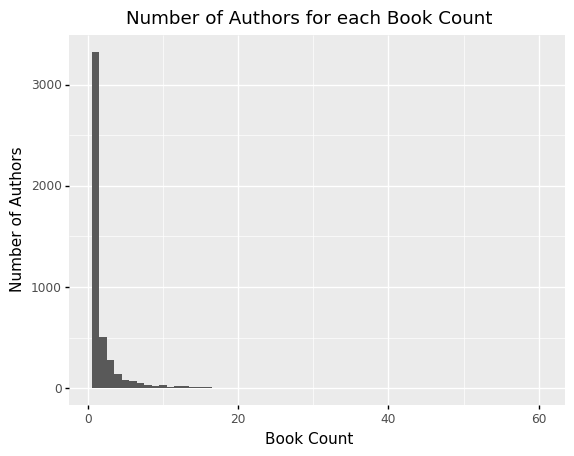

<ggplot: (8792954277879)>

In [ ]:
grouped = books.groupby('authors')['authors'].agg({'count'})
(ggplot(data=grouped)
    + geom_histogram(aes(x='count'), binwidth=1)
    + labs(title='Number of Authors for each Book Count', x='Book Count', y='Number of Authors')
)

<h2>Language Code Distribution</h3>

From the plot below, we can learn that:
- The majority of the books are written in English.

<h3>Since we will take a query string, assuming that the query will be an English word, we have to disregard non-English books.</h3>

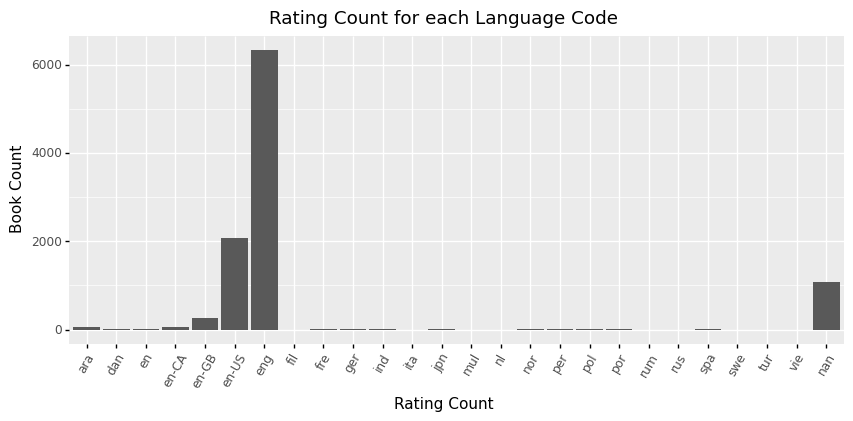

<ggplot: (8792954076290)>

In [ ]:
grouped = books.groupby('language_code')['language_code'].agg({'count'})
(ggplot(data=books)
    + geom_bar(aes(x='language_code'))
    + labs(title='Rating Count for each Language Code', x='Rating Count', y='Book Count')
    + theme(axis_text_x=element_text(rotation=60), figure_size=(10,4))
)

<h2>Tag Name Distribution</h2>

From the plot and table below, we can learn that:
- The most used tag name is "to-read".
- There are 34252 tag names.
- There are many non-ascii & non-readable & digits-only tag names.

<h3>Therefore, there is a huge imbalance in tag name distribution and we have to filter out weird tag names.</h3>

In [ ]:
tags.iloc[34000:]

,tag_id,tag_name
34000,34000,قصص-قصيرة-مقالات
34001,34001,قصص-قصيره
34002,34002,قصص-و-روايات
34003,34003,قصص-وروايات
34004,34004,قوة-العقل-الباطن
...,...,...
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ


Unique Tag Name Count 34252


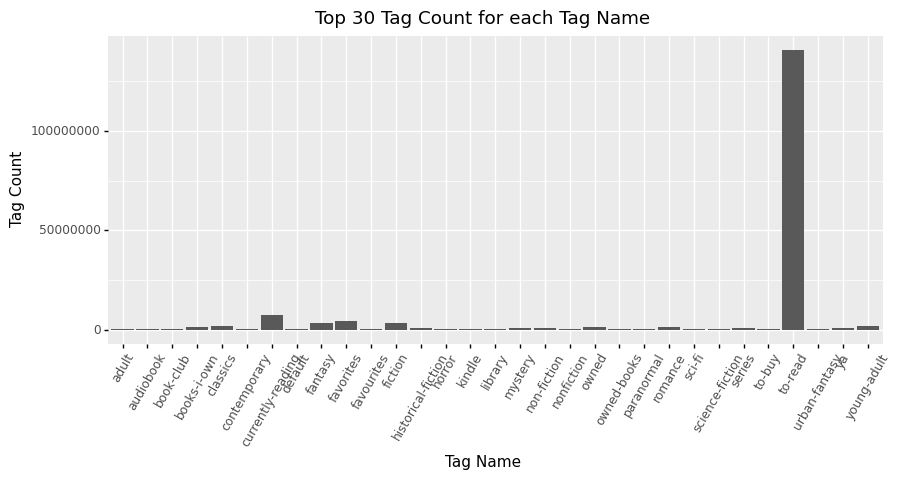

<ggplot: (8792954379460)>

In [ ]:
merged = pd.merge(book_tags, tags, on='tag_id')
print('Unique Tag Name Count', len(merged['tag_name'].unique()))
grouped = merged.groupby('tag_name')['count'].agg({'sum'})
grouped = grouped.sort_values(by='sum', ascending=False).reset_index()
grouped = grouped.dropna()
(ggplot(data=grouped.loc[:30])
    + geom_bar(aes(x='tag_name', y='sum'), stat='identity')
    + labs(title='Top 30 Tag Count for each Tag Name', x='Tag Name', y='Tag Count')
    + theme(axis_text_x=element_text(rotation=60), figure_size=(10,4))
)

<h2>Average Number of Seen Books</h2>

From the table below, we can learn that:
- On average, each user has read around 110 books.

In [ ]:
grouped = ratings.groupby(['user_id'])['book_id'].agg({'count'})
pd.DataFrame(grouped['count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
count,53424.0,111.868804,26.071224,19.0,96.0,111.0,128.0,200.0


---
<h1>Exploratory Data Analysis Summary</h1>

- Keep English books only.
- Recommend books only if their "IMDB" weighted rating is greater than 3.2.
- Remove weird tags like non-ascii & non-readable & digits-only tags.

---
<h1>Data Processing</h1> 

In [ ]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

In [ ]:
# checking any inappropirate data
print(books['book_id'].isna().sum())
print(books['title'].isna().sum())
print(books['authors'].isna().sum())
print(tags.isna().sum())

0
0
0
tag_id      0
tag_name    0
dtype: int64


<h2>Removing weird tags like non-ascii & non-readable & digits-only tags</h2>

- We serach if the tag is an English word of not using nltk.words.words()

In [ ]:
indices = []
_tags = tags[tags['tag_name'].str.contains('[A-Za-z]')].reset_index(drop=True)

set_of_words = set(words.words())
# special_characters = ['~', ':', "'", '+', '[', '\\', '@', '^', '{', '%', '(', '"', '*', '|', ',', '&', '<', '`', '}', '.', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/']

for i, row in _tags.iterrows():
    tag_name = row['tag_name']
    if tag_name.isascii():
        tag_name_list = tag_name.split('-')
        is_word = True
        for _tag in tag_name_list:
            if _tag.isdigit() or _tag not in set_of_words: # or _tag in special_characters:
                is_word = False
        if is_word:
            indices.append(i)

_tags = _tags.drop_duplicates(ignore_index=True)
_tags = _tags.iloc[indices, :].reset_index(drop=True)

print(_tags.shape)
_tags.head()

(11357, 2)


,tag_id,tag_name
0,1291,a
1,1293,a-a-fiction
2,1297,a-baker-s-education
3,1298,a-beautiful-dark
4,1305,a-corner-of-the-universe


In [ ]:
_book_tags = pd.merge(_tags, book_tags, on='tag_id')

_book_tags = _book_tags.sort_values(by='count', ascending=False)
_book_tags = _book_tags.groupby('goodreads_book_id')['tag_name'].agg({'unique'}).reset_index()
_book_tags.columns = ['goodreads_book_id', 'tag_name']

_book_tags.head()

,goodreads_book_id,tag_name
0,1,"[to-read, fantasy, currently-reading, young-ad..."
1,2,"[to-read, currently-reading, fantasy, default,..."
2,3,"[to-read, fantasy, currently-reading, young-ad..."
3,5,"[fantasy, currently-reading, young-adult, to-r..."
4,6,"[fantasy, young-adult, fiction, harry-potter, ..."


<h2>Keeping English books only and Generating a new string column to use for TF-IDF</h2>

- Since we are going to take any type of a string query to search recommendable books, we are going to concatenate the book's authors & title & tag names into one string.
    - This string will be used for generating a TF-IDF matrix.
    - TF-IDF computes a weight to each word which reflects the importance of the word in the corpus.
    - TF-IDF will work better than count vectorization because there is a huge imbalance in the tag name distribution.

<h2>Sorting the books table by ratings count and average rating</h2>

In [ ]:
_books = books[['book_id', 'goodreads_book_id', 'authors', 'title', 'ratings_count', 'average_rating', 'language_code']]
_books = pd.merge(_books, _book_tags, on='goodreads_book_id')
_books['tag_name'] = _books['tag_name'].apply(lambda x: ' '.join(map(str, x)))

_books = _books.assign(authors=_books['authors'].str.replace(',', ' '))
_books['name'] = _books['authors'] + ' ' + _books['title'] + ' ' + _books['tag_name']

language_codes = ['en-CA', 'en-GB', 'en-US', 'eng', 'en']
_books = _books[_books['language_code'].isin(language_codes)]

_books = _books.sort_values(by=['ratings_count', 'average_rating'], ascending=False)
_books = _books.reset_index(drop=True)

print('Books shape', books.shape)
_books.head()

Books shape (10000, 23)


,book_id,goodreads_book_id,authors,title,ratings_count,average_rating,language_code,tag_name,name
0,1,2767052,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,eng,currently-reading young-adult fiction to-read ...,Suzanne Collins The Hunger Games (The Hunger G...
1,2,3,J.K. Rowling Mary GrandPré,Harry Potter and the Sorcerer's Stone (Harry P...,4602479,4.44,eng,to-read fantasy currently-reading young-adult ...,J.K. Rowling Mary GrandPré Harry Potter and t...
2,3,41865,Stephenie Meyer,"Twilight (Twilight, #1)",3866839,3.57,en-US,young-adult fantasy ya fiction to-read paranor...,"Stephenie Meyer Twilight (Twilight, #1) young-..."
3,4,2657,Harper Lee,To Kill a Mockingbird,3198671,4.25,eng,to-read classic historical-fiction school lite...,Harper Lee To Kill a Mockingbird to-read class...
4,5,4671,F. Scott Fitzgerald,The Great Gatsby,2683664,3.89,eng,fiction classic literature school historical-f...,F. Scott Fitzgerald The Great Gatsby fiction c...


<h2>New string for TF-IDF concatnating the book's authors & title & tag names</h2>

In [ ]:
_books.loc[0, 'name']

'Suzanne Collins The Hunger Games (The Hunger Games, #1) currently-reading young-adult fiction to-read fantasy ya science-fiction series romance adventure book-club kindle teen post-apocalyptic action re-read ya-fiction survival favorite i-own young-adult-fiction thriller futuristic default library suspense reread my-library audio favorite-series teen-fiction ya-lit own-it finished action-adventure love love-triangle coming-of-age to-buy novel read-more-than-once ya-fantasy future contemporary trilogy e-book speculative-fiction finished-series drama'

---
<h1>TF-IDF & Cosine Similarity - Item-based Book Recommendation</h1>

<h2>Generating TF-IDF matrix & Computing the cosine similarity</h2>

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', lowercase=True, token_pattern=r'\S+')
tfidf_matrix = tfidf.fit_transform(_books['name'])
# print(tfidf.get_feature_names())
tfidf_matrix.shape

(8730, 23969)

In [ ]:
cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

cosine_matrix.shape

(8730, 8730)

---
<h1>KNN - Item-based Collaborative Filtering</h1>

- Since we are providing a personalized recommendation system, we should also utilize a collaborative filtering algorithm where the user's ratings are taken into account.
    - We want to find neighboring/ similar books to the user's query.
        - Therefore, we are going to use item-based collaborative filtering using KNN.
- To evaluate the performance of KNN, train and test sets are created.
    - Evaluation metric: RMSE.
- User-based collaborative filtering methods not chosen.
    - Because Neeva prioritizes user privacy, item-based collaborative filtering would be more appropriate.
    - Since we are taking a query, an item-based approach is, once again, more appropriate.
- The train and test datasets are simply for the evaluation purpose. For the final recommendation system, the entire dataset will be used.

<h2>Creating train & test sets for evaluation</h2>

In [ ]:
_ratings = pd.merge(ratings, _books['book_id'], on='book_id')
_ratings = _ratings[['user_id', 'book_id', 'rating']]
train, test = sklearn.model_selection.train_test_split(_ratings, test_size=0.1, shuffle=True, random_state=0)
train = train.sort_values(by=['rating', 'book_id'], ascending=[False, True])
train = train.reset_index(drop=True)
test = test.sort_values(by=['rating', 'book_id'], ascending=[False, True])
test = test.reset_index(drop=True)

In [ ]:
train.groupby('user_id')['book_id'].agg({'unique'}).head()

,unique
user_id,
1,"[4, 11, 35, 70, 81, 102, 128, 136, 143, 258, 4..."
2,"[2, 5, 10, 15, 18, 23, 24, 25, 27, 54, 80, 82,..."
3,"[4090, 7401, 4, 15, 59, 118, 247, 410, 715, 76..."
4,"[2, 10, 21, 23, 24, 25, 27, 35, 36, 42, 81, 85..."
5,"[164, 451, 458, 623, 794, 852, 1182, 1345, 134..."


In [ ]:
test.groupby('user_id')['book_id'].agg({'unique'}).head()

,unique
user_id,
1,"[177, 2133, 36, 100, 54, 111, 115, 119, 268, 3..."
2,"[21, 160, 630, 8, 125, 7341]"
3,"[659, 1929, 427, 55, 660, 2235, 2615, 4057, 9966]"
4,"[18, 8, 11, 58, 62, 70, 101, 129, 221, 297, 33..."
5,"[1195, 5117, 1742, 3378, 4380, 4942, 1744, 281..."


<h2>KNN evalution & RMSE </h2>

As the result below shows:
- For k value, we chose the max book count for each user.

In [ ]:
reader = surprise.Reader(rating_scale=(1, 5))
sp_train = surprise.Dataset.load_from_df(train, reader)
sp_train = sp_train.build_full_trainset()
sp_test = surprise.Dataset.load_from_df(test, reader)
_, sp_test = surprise.model_selection.split.train_test_split(sp_test, test_size=1.0)

k = train.groupby('user_id').count().describe().loc['max', 'book_id']
sim_options = {'name': 'pearson', 'user_based': False}  # compute similarities between items
knn = surprise.KNNBasic(k=int(k), sim_options=sim_options)
knn.fit(sp_train)
knn_pred = knn.test(sp_test)
surprise.accuracy.rmse(knn_pred, verbose=True)

# _knn_pred = pd.DataFrame(knn_pred, columns=['user_id', 'item_id', 'ground_truth', 'prediction', 'details'])
# _knn_pred.drop(columns='details', inplace=True)
# _knn_pred['rmse'] = abs(_knn_pred['ground_truth'] - _knn_pred['prediction'])
# _knn_pred = _knn_pred.sort_values(by='rmse', ascending=True)

# _knn_pred.head()

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8931


0.8930887624244067

---
<h1>Final Recommendation System</h1>

<h2>Final KNN model with all user information</h2>

In [ ]:
sp_data = surprise.Dataset.load_from_df(_ratings, reader)
sp_data = sp_data.build_full_trainset()

k = _ratings.groupby('user_id').count().describe().loc['max', 'book_id']
sim_options = {'name': 'pearson', 'user_based': False}
all_knn = surprise.KNNBasic(k=int(k), sim_options=sim_options)
all_knn.fit(sp_data)

Computing the cosine similarity matrix...
Done computing similarity matrix.


<h2>Generating "easy book id & table index & book title search dictionaries"</h2>

In [ ]:
book_id_2_idx = {}
idx_2_book_id = {}
book_id_2_title = {}

for i, row in _books.iterrows():
    book_id = row['book_id']
    title = row['title']
    
    book_id_2_idx[book_id] = i
    book_id_2_title[book_id] = title
    
    idx_2_book_id[i] = book_id

<h2>Each user's "finished-reading" book lists & Sorting the table by rating</h2>

In [ ]:
_ratings = _ratings.sort_values(by=['rating', 'book_id'], ascending=[False, True])
seen = _ratings.groupby('user_id')['book_id'].agg({'unique'}).reset_index()
seen.columns = ['user_id', 'book_ids']

seen.head()

,user_id,book_ids
0,1,"[4, 11, 35, 70, 81, 102, 128, 136, 143, 177, 2..."
1,2,"[2, 5, 10, 15, 18, 21, 23, 24, 25, 27, 54, 80,..."
2,3,"[4090, 7401, 4, 15, 59, 118, 247, 410, 659, 71..."
3,4,"[2, 10, 18, 21, 23, 24, 25, 27, 35, 36, 42, 81..."
4,5,"[164, 451, 458, 623, 794, 852, 1182, 1195, 134..."


<h2>Each user's "to-read" book lists & Sorting the table by average rating</h2>

In [ ]:
_to_read = pd.merge(to_read, _books[['book_id', 'average_rating']], on='book_id')
_to_read = _to_read.sort_values(by=['average_rating', 'book_id'], ascending=[False, True])
_to_read = to_read.groupby('user_id')['book_id'].agg({'unique'}).reset_index()
_to_read.columns = ['user_id', 'book_ids']

_to_read.head()

,user_id,book_ids
0,1,"[1874, 235, 1198, 533, 112, 2058, 3334]"
1,2,"[7873, 2220, 4, 13, 439, 113, 3227, 408, 1969,..."
2,3,"[5448, 3566, 2439, 932, 1146, 726, 8403, 4582,..."
3,5,"[3581, 31, 665, 3074]"
4,6,"[687, 619, 5269, 5537, 874, 1912, 649, 7480, 6..."


<h2>Final Recommendation System</h2>

1. Take in any type of book-hunting intent query.
2. Check if the query is associated with any of the user's reading information.
    1. If the query is found in the user's book history, get the matched book id that has the highest user rating.
    2. Else if the query if found in the user's "to read" list, get the matched book id that has the highest average rating.
    3. Else if the query if found in the total books list, get the matched book id that has the highest average rating.
    4. Else, there is no matched book found - terminate the recommendation system.
3. Using the matched id from step 2, get top related <i>k</i> books from TF-IDF & Cosine Similarity result as well as the KNN result.
4. Find the books that are both present in the TF-IDF & Cosine Similarity result as well as the KNN result.
5. Use "IMDb" weighted rating + Cosine Similarity score to sort the recommendation list by rating.

In [ ]:
def get_from_query(u, q, k, seen):

    """
    Provide users a personalized search experience for any type of book-hunting intent query

    Args:
        u: user id
        q: any type of book-hunting intent query - could be a string for a title, tag and author names
        k: number of neighbors/ similar books to retrieve
        seen: the user's "already finished reading" book list
        prioritize_knn: boolean to indicate whether the order of the "nearset neighbors nees to be prioritized
    
    Returns:
        list: top <=100 book recommendations with its matching score (%)
    """

    if u not in seen[seen['user_id'] == u]['user_id'].unique():
        return 'User ID does not exist!'

    if len(q) == 0:
        return 'Wrong query!'
        
    q = q.lower()
    seen_list = seen[seen['user_id'] == u]['book_ids'].squeeze()
    if isinstance(seen_list, np.ndarray):
        seen_list = seen_list.tolist()
        
    to_read_list = _to_read[_to_read['user_id'] == u]['book_ids'].squeeze()
    if isinstance(to_read_list, np.ndarray):
        to_read_list = to_read_list.tolist()

    # all the book_ids from these lists are sorted in 'average_rating' order (highest avg. rating first)
    seen_get_query_list = _books['book_id'][_books['book_id'].isin(seen_list) & _books['name'].str.lower().str.contains(q)].to_numpy().tolist()
    to_read_get_query_list = _books['book_id'][_books['book_id'].isin(to_read_list) & _books['name'].str.lower().str.contains(q)].to_numpy().tolist()
    books_get_query_list = _books['book_id'][_books['name'].str.lower().str.contains(q)].to_numpy().tolist()

    book_id = 0
    
    if len(seen_get_query_list) != 0:
        # if the searched query is in the user's previous history
        book_id = seen_get_query_list[0]
    elif len(to_read_get_query_list) != 0:
        # if the searched query is in the user's marked book lists
        book_id = to_read_get_query_list[0]
    elif len(books_get_query_list) != 0:
        # if the searched query is in the total book repository
        book_id = books_get_query_list[0]
    else:
        return 'No book found!'
    
    # print(book_id)
    idx = book_id_2_idx[book_id]
    print(book_id_2_title[book_id])
    sim_scores = [(idx_2_book_id[i], score) for i, score in enumerate(cosine_matrix[idx]) if i != idx]
    sim_scores = list(sorted(sim_scores, key=lambda x: x[1], reverse=True))
    sim_scores = dict(sim_scores[:k])

    iid = all_knn.trainset.to_inner_iid(book_id)
    neighbors = all_knn.get_neighbors(iid, k=k)[::-1]
    recommendations = []
    for rec_iid in neighbors:
        rec_id = all_knn.trainset.to_raw_iid(rec_iid)
        if rec_id not in seen_list and rec_id in sim_scores.keys():

            sim_score = sim_scores[rec_id]
            rec_title = book_id_2_title[rec_id]
            v = _books[_books['book_id'] == rec_id]['ratings_count'].item()
            m = _books['ratings_count'].min()
            R = _books[_books['book_id'] == rec_id]['average_rating'].item()
            C = _books['average_rating'].mean()
            weighted_score = ((R * v + C * m) / (v + m)) 

            if weighted_score <= 3.2:
                # we don't want to recommend bad books
                continue
            weighted_score = weighted_score / 5.0 # converting the score to a percentage value
            total_score = (sim_score + weighted_score) / 2.0

            if rec_id in to_read_list:
                recommendations.append((rec_title, total_score * 1.5 * 100))
            else:
                recommendations.append((rec_title, total_score * 100))
                
    if len(recommendations) == 0:
        return 'Could not find books that match your taste :('
    
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return recommendations[:100]

<h1>Some Examples and Results</h1>

In [ ]:
k = _ratings.groupby('user_id').count().describe().loc['max', 'book_id']
get_from_query(u=1, q='hunger', k=int(k), seen=seen)

The Hunger Games (The Hunger Games, #1)


[('The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)', 86.435351676183),
 ('Catching Fire (The Hunger Games, #2)', 82.79868630958806),
 ('The Hunger Games: Official Illustrated Movie Companion', 61.00290345783065),
 ('The World of the Hunger Games (Hunger Games Trilogy)', 57.69678602614698),
 ('The Hunger Games Tribute Guide', 57.12243495331103),
 ('Cress (The Lunar Chronicles, #3)', 55.49802769625203),
 ('UnDivided (Unwind, #4)', 55.272323514456225),
 ('UnSouled (Unwind, #3)', 54.623514525096574),
 ('Gemina (The Illuminae Files, #2)', 54.59705006058169),
 ('The Dead of Night (Tomorrow, #2)', 54.51063941165742),
 ('Burning For Revenge (Tomorrow, #5)', 53.789355291886366),
 ('The Night Is for Hunting (Tomorrow, #6)', 52.886048382461226),
 ("The Girl Who Was on Fire: Your Favorite Authors on Suzanne Collins' Hunger Games Trilogy",
  52.44345115112017)]

In [ ]:
get_from_query(u=1, q='love', k=int(k), seen=seen)

Pride and Prejudice


[('Persuasion', 69.05534860793679),
 ('The Complete Novels', 61.938602010885944),
 ('The Grand Sophy', 53.80679782153494),
 ('Ross Poldark (Poldark, #1)', 53.31516576603333)]

In [ ]:
get_from_query(u=1, q='harry', k=int(k), seen=seen)

Harry Potter and the Sorcerer's Stone (Harry Potter, #1)


[('Harry Potter and the Goblet of Fire (Harry Potter, #4)', 85.78315965560847),
 ('Harry Potter and the Chamber of Secrets (Harry Potter, #2)',
  85.57520853379191),
 ('Harry Potter and the Deathly Hallows (Harry Potter, #7)',
  84.66153864043464),
 ('Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
  84.0295293246285),
 ('Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
  81.85241244494053),
 ('Harry Potter Boxset (Harry Potter, #1-7)', 79.00643735773379),
 ('Harry Potter Collection (Harry Potter, #1-6)', 77.64689991650211),
 ('The Harry Potter Collection 1-4 (Harry Potter, #1-4)', 76.45201028189565),
 ('Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
  76.35075253385898),
 ('Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)', 71.02703125542831),
 ('Fantastic Beasts and Where to Find Them: The Original Screenplay',
  56.042804253091624),
 ('Short Stories from Hogwarts of Heroism, Hardship and Dangerous Hobbies (Pottermore Presents, #1)',
  5